In [29]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.multiclass import OneVsOneClassifier
# Preprocessing and visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

# Metric functions
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score

# Models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.dummy        import DummyClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.svm          import SVC

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Ignore warnings if they happen, we don't care (that much)
import warnings; warnings.simplefilter('ignore')

# Cross-validation takes a minute, so we will save these models
from sklearn.externals import joblib

In [16]:
df     = pd.read_csv("data/lyrical_genius.csv")

# Remove pop songs, they are all over the place and hurt classification
df = df[(df["Genre"] != "pop")]

# Remove some irrelevant columns
df = df.drop(columns="Unnamed: 0")
df = df.drop(columns="Unnamed: 0.1")

# We go ahead and remove ALL duplicates
df = df.drop_duplicates(subset=["Name","Artist"],keep=False)

# Give each genre a new cool color
genres = df["Genre"].unique()
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080'
]
colors = {}
i = 0
for genre in genres:
    colors[genre] = unique_colors[i]
    i+=1
    
# Upsample the amount of occurances of values that don't appear very often
# df = df.append(df[((df["Genre"] != "country") & (df["Genre"] != "edm_dance"))])
extras    = df.copy()
counts    = df["Genre"].value_counts()
max_count = max(df["Genre"].value_counts())
for genre in genres:
    needed = max_count - counts[genre]
    extras = extras.append(df[df["Genre"]==genre].sample(n=needed,replace=True))
df = extras
counts    = df["Genre"].value_counts()
colors_list = [colors[genre] for genre in genres]

df.head()

,Genre,Id,Popularity,Is_Exp,Name,Artist,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time_Signature,Lyrics
0,rnb,3ibKnFDaa3GhpPGlOUj7ff,80,False,Let Me Love You,Mario,0.656,0.578,7,-8.970,0,0.0922,0.2350,0.0,0.1180,0.556,94.514,4,"Mmmm Mmmmm Yeah Mmmmm Yeah, yeah, yeah Mmmm Y..."
1,rnb,2aIdVb8v9KTpEZnftkz2mD,78,False,Buy U a Drank (Shawty Snappin'),T-Pain,0.451,0.550,1,-8.137,1,0.2620,0.0108,0.0,0.0737,0.594,80.001,4,None
2,rnb,7DFnq8FYhHMCylykf6ZCxA,69,False,Yo (Excuse Me Miss),Chris Brown,0.536,0.612,4,-5.847,1,0.2720,0.1190,0.0,0.2090,0.570,86.768,4,Let’s get ONE. THING. STRAIGHT! Certain shit ...
3,rnb,39YovPslPCXbFYhlYjsZ2Y,67,False,Don't Mess With My Man,Nivea,0.879,0.730,11,-4.369,0,0.1640,0.1140,0.0,0.2410,0.885,99.925,4,"] Uh, I like it baby, uh Uh, one time for the..."
4,rnb,3LmvfNUQtglbTrydsdIqFU,72,False,We Belong Together,Mariah Carey,0.838,0.469,0,-7.992,1,0.0835,0.0358,0.0,0.0928,0.778,139.975,4,"Ooh, oh oh Sweet love, yeah I didn't mean i..."


In [17]:
# Split data into data frames of the right type
x_cols    = ["Is_Exp","Danceability","Energy","Key","Loudness","Mode","Speechiness","Acousticness","Instrumentalness","Liveness","Valence","Tempo","Time_Signature"]
y_cols    = ["Genre"]
meta_cols = ["Id","Popularity","Name","Artist"]

X,y,meta = df[x_cols],df[y_cols].iloc[:,0],df[meta_cols]

In [18]:
# Scale the data and fit run 2D PCA on it
scaler   = StandardScaler()
scaled_X = scaler.fit_transform(X)
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(scaled_X)
prin_df   = pd.DataFrame(data=prin_comp, columns=["PC1","PC2"])

In [19]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y, test_size=.2, random_state=1234, stratify=y)

In [ ]:
clf = LogisticRegressionCV(cv=5, random_state=1234, multi_class="multinomial")
clf.fit(X_train,y_train)

print(clf)

joblib.dump(clf, "logistic.pkl")
y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(genres)
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 

In [ ]:
for i in range(len(clf.classes_)):
    print(clf.classes_[i])
    todos      = [(clf.coef_[i][j],list(X)[j]) for j in range(len(list(X)))]
    todos.sort(key=lambda x: abs(x[0]))
    for i in range(len(todos)):
        print(todos[i])
    

In [20]:
def best_classifier(X, y, t_clf, params) :
    """
    Sweeps different settings for the hyperparameters of a Decision Tree classifier,
    calculating the k-fold CV performance for each setting and metric,
    then selects the hyperparameters that maximize the average performance for each metric.
    """
    clf  = GridSearchCV(t_clf, params, cv=5,scoring= "accuracy")
    
    clf.fit(X,y)
    return clf.best_estimator_

In [ ]:
weights = ["uniform","distance"]
pvals   = [1,2]
n_neigh = range(1,40,2)
params  = {
    "p": range(5,22,2),
    "weights": weights,
    "p": pvals,
}
knn = KNeighborsClassifier()
clf = best_classifier(X_train,y_train,knn,params)

print(clf)

joblib.dump(clf, "knn.pkl")

y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 

In [21]:
params = {
    "max_depth": range(5,12),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini","entropy"]
}
t = DecisionTreeClassifier()

DTree = best_classifier(X_train, y_train, t, params)

print(DTree)

joblib.dump(DTree, "dtree.pkl")

# predict genres of test data
accuracy = DTree.score(X_test,y_test)
y_pred = DTree.predict(X_test)
training = DTree.score(X_train, y_train)
testing  = DTree.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Training Accuracy: 0.895306320423849
Testing  Accuracy: 0.864816472694718
[[496  37  14   0   0  12]
 [ 41 512   2   0   2   2]
 [ 59   2 440   1  12  44]
 [  2   1  10 534   7   5]
 [ 24   5  27   0 456  46]
 [ 38   3  49   0   8 460]]
              precision    recall  f1-score   support

   classical       1.00      0.96      0.98       559
     country       0.81      0.79      0.80       558
   edm_dance       0.94      0.82      0.87       558
      hiphop       0.91      0.92      0.92       559
         rnb       0.75      0.89      0.81       559
        rock       0.81      0.82      0.82       558

   micro avg       0.86      0.86  

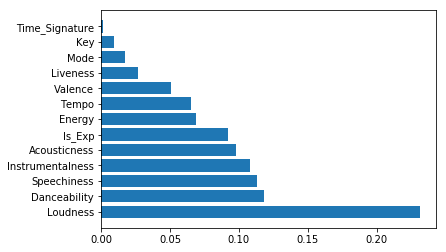

In [58]:
importance = DTree.feature_importances_
d_feats      = list(X)
todos      = [(importance[i],d_feats[i]) for i in range(len(d_feats))]
todos.sort(key=lambda x: x[0],reverse=True)

f_importances(importance, x_cols)

In [57]:
todos

[(0.23132129084845765, 'Loudness'),
 (0.11820472624765307, 'Danceability'),
 (0.1128827158338075, 'Speechiness'),
 (0.10797252974874455, 'Instrumentalness'),
 (0.09787018813332006, 'Acousticness'),
 (0.0922616527576782, 'Is_Exp'),
 (0.0688575147598251, 'Energy'),
 (0.06548703032041639, 'Tempo'),
 (0.05077355272784004, 'Valence'),
 (0.026710280449575755, 'Liveness'),
 (0.01737890418980047, 'Mode'),
 (0.009082656327934214, 'Key'),
 (0.0011969576549469816, 'Time_Signature')]

In [24]:
params

{'max_depth': range(5, 12),
 'min_samples_leaf': range(1, 10),
 'criterion': ['gini', 'entropy']}

In [ ]:
# compare to stratified dummy classifier
dummy = DummyClassifier(strategy='stratified')

joblib.dump(dummy, "dummy.pkl")

dummy.fit(X_train,y_train)
dummy_accuracy = dummy.score(X_test,y_test)
print( "Dummy classifier accuracy is" )
print(dummy_accuracy)

In [25]:
params  = {
    "C": 10.0 ** np.arange(-3, 3)
}
lin_svm = SVC(kernel="linear", probability=True)
clf = best_classifier(X_train,y_train,lin_svm,params)

print(clf)

joblib.dump(clf, "lin_svm.pkl")

y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training Accuracy: 0.7211402134169091
Testing  Accuracy: 0.7030737093404954
[[287 122  87   1  25  37]
 [ 78 460   7   0  11   3]
 [ 42   6 391   8  26  85]
 [  1   1  12 533   8   4]
 [ 44  22  55   4 365  68]
 [ 38  18 130   0  52 320]]
              precision    recall  f1-score   support

   classical       0.98      0.95      0.96       559
     country       0.57      0.70      0.63       558
   edm_dance       0.75      0.65      0.70       558
      hiphop       0.73      0.82      0.77       559
         rnb       0.59      0.51      0.55       559
        rock       0.62      0.57      0.60       558

   micro avg       0.70      0.70      0.70      3351
   macro avg       0.71      0.70      0.70      3351
weighted avg       0.71      0.70 

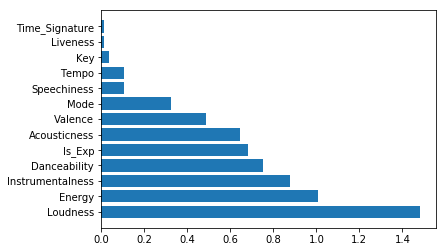

In [56]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

f_importances(abs(clf.coef_[0]), x_cols)

In [9]:
params  = {
    "C": 10.0 ** np.arange(-3, 3),
    "gamma": float(X.shape[0]) ** np.arange(-3, 2)
}
rbf_svm = SVC(kernel="rbf")
clf = best_classifier(X_train,y_train,rbf_svm,params)

print(clf)

joblib.dump(clf, "rbf_svm.pkl")

y_pred = clf.predict(X_test)
training = clf.score(X_train, y_train)
testing  = clf.score(X_test,  y_test)
print("Training Accuracy: {}".format(training))
print("Testing  Accuracy: {}".format(testing))
print(confusion_matrix(y_test,y_pred,labels=genres))
print(classification_report(y_test, y_pred)) 


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00017717930545712261,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training Accuracy: 0.82281284606866
Testing  Accuracy: 0.8210806023029229
[[  7  18  26   1  11   2]
 [  7  60   7   0   7   0]
 [  0   0 159   7   9   5]
 [  0   1   9 545   4   0]
 [  3   5  26   3 130   2]
 [  3   2  26   0  18  26]]
              precision    recall  f1-score   support

   classical       0.98      0.97      0.98       559
     country       0.63      0.88      0.73       180
   edm_dance       0.73      0.77      0.75       169
      hiphop       0.70      0.74      0.72        81
         rnb       0.35      0.11      0.16        65
        rock       0.74      0.35      0.47        75

   micro avg       0.82      0.82      0.82      1129
   macro avg       0.69      0.64      0.64      1129
weighted avg       0.81      0.8